In [3]:
import datetime
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import (Dense)
import tqdm
from typing import Tuple,List


In [4]:
env = gym.make("CartPole-v1")

# Set seed for experiment reproducibility
seed = 49
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

In [5]:
def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    state, reward, done, _ = env.step(action)
    return (
        state.astype(np.float32),
        np.array(reward, np.int32),
        np.array(done, np.int32)
    )

def tf_env_step(action: tf.Tensor):
    return tf.numpy_function(
        env_step, [action], [tf.float32, tf.int32, tf.int32]
    )

In [6]:
def get_expected_return(
    rewards: tf.Tensor,
    gamma: float,
    standardize: bool = True) -> tf.Tensor:
    n = tf.shape(rewards)[0]
    returns = tf.TensorArray(dtype=tf.float32, size=n)
    
    rewards = tf.cast(rewards[::-1], dtype=tf.float32)
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape
    for i in tf.range(n):
        reward = rewards[i]
        discounted_sum = reward + gamma * discounted_sum
        discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(i, discounted_sum)
    returns = returns.stack()[::-1]

    if standardize:
        returns = ((returns - tf.math.reduce_mean(returns)) / (tf.math.reduce_std(returns) + eps))
    return returns

In [7]:
def train(agent, max_episodes=10000, max_steps_per_episode=1000):
    gamma = .99
    running_reward = 0
    reward_threshold = 195
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/gradient_tape/' + type(agent).__name__ + current_time + '/train'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    with tqdm.trange(max_episodes) as t:
        for i in t:
            initial_state = tf.constant(env.reset(), dtype=tf.float32)
            episode_reward = int(agent.train_step(initial_state, gamma, max_steps_per_episode))

            running_reward = episode_reward * .01 + running_reward * .99

            t.set_description(f"Episode {i}")
            t.set_postfix(episode_reward=episode_reward, running_reward=running_reward)

            with train_summary_writer.as_default():
                tf.summary.scalar(f'running_reward ({type(agent).__name__})', running_reward, step=i)
                tf.summary.scalar(f'reward ({type(agent).__name__})', episode_reward, step=i)

            if running_reward > reward_threshold:
                break
    print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

 ### Reinforce ###

In [8]:
def run_episode(
    initial_state: tf.Tensor,
    policy: tf.keras.Model,
    max_steps: int
) -> Tuple[tf.Tensor,tf.Tensor]:
    action_probs = tf.TensorArray(tf.float32, 0, True)
    rewards = tf.TensorArray(tf.int32, 0, True)

    initial_state_shape = initial_state.shape
    state = initial_state

    for t in tf.range(max_steps):
        state = tf.expand_dims(state, 0)

        action_logits_t = policy(state)

        action = tf.random.categorical(action_logits_t, 1)[0, 0]
        action_probs_t = tf.nn.softmax(action_logits_t)

        action_probs = action_probs.write(t, action_probs_t[0, action])

        state, reward, done = tf_env_step(action)

        state.set_shape(initial_state_shape)

        rewards = rewards.write(t, reward)

        if tf.cast(done, tf.bool):
            break

    action_probs = action_probs.stack()
    rewards = rewards.stack()

    return action_probs, rewards

In [9]:
def compute_loss(
  action_probs: tf.Tensor,
  returns: tf.Tensor
) -> tf.Tensor:
    action_log_probs = tf.math.log(action_probs)
    loss = -tf.math.reduce_sum(action_log_probs * returns)
    return loss

In [10]:
class Policy(tf.keras.Model):
    def __init__(self,n_actions:int):
        super(Policy, self).__init__(name='Policy')
        self.fc1 = Dense(6,activation='relu')
        self.fc2 = Dense(n_actions)

    def call(self, inputs: tf.Tensor):
        x = self.fc1(inputs)
        return self.fc2(x)


class Reinforce:
    def __init__(self,n_actions,gamma = .99, lr=.001):
        self.gamma = gamma
        self.policy = Policy(n_actions=n_actions)
        self.optim = optimizers.Adam(learning_rate=lr)

    def save(self):
        self.policy.save('policy')

    def load(self):
        self.policy = tf.keras.models.load_model('policy')

    @tf.function
    def train_step(self,initial_state: tf.Tensor,gamma:float,max_steps_per_episode: int) -> tf.Tensor:
        with tf.GradientTape() as tape:
            action_probs,rewards = run_episode(initial_state,self.policy,max_steps_per_episode)
            returns = get_expected_return(rewards,gamma)

            action_probs,returns = [
                tf.expand_dims(x,1) for x in [action_probs,returns]
            ]

            loss = compute_loss(action_probs,returns)
        grads = tape.gradient(loss,self.policy.trainable_variables)
        self.optim.apply_gradients(zip(grads,self.policy.trainable_variables))
        episode_reward = tf.math.reduce_sum(rewards)
        return episode_reward


In [11]:
reinforce_agent = Reinforce(env.action_space.n)
train(reinforce_agent)

Episode 1238:  12%|█▏        | 1238/10000 [01:22<09:42, 15.04it/s, episode_reward=439, running_reward=196]


Solved at episode 1238: average reward: 196.26!


In [12]:
%load_ext tensorboard
%tensorboard --logdir logs/gradient_tape

Reusing TensorBoard on port 6010 (pid 17100), started 0:25:14 ago. (Use '!kill 17100' to kill it.)

 ### Reinforce with BaseLine ###

In [13]:
def run_episode(
    initial_state: tf.Tensor,
    policy: tf.keras.Model,
    critic: tf.keras.Model,
    max_steps: int
) -> List[tf.Tensor]:
    action_probs = tf.TensorArray(tf.float32, 0, True)
    values = tf.TensorArray(tf.float32,0,True)
    rewards = tf.TensorArray(tf.int32, 0, True)

    initial_state_shape = initial_state.shape
    state = initial_state

    for t in tf.range(max_steps):
        state = tf.expand_dims(state, 0)

        action_logits_t = policy(state)
        value = critic(state)

        action = tf.random.categorical(action_logits_t, 1)[0, 0]
        action_probs_t = tf.nn.softmax(action_logits_t)

        action_probs = action_probs.write(t, action_probs_t[0, action])
        values = values.write(t,value)
        

        state, reward, done = tf_env_step(action)

        state.set_shape(initial_state_shape)

        rewards = rewards.write(t, reward)

        if tf.cast(done, tf.bool):
            break

    action_probs = action_probs.stack()
    values = values.stack()
    rewards = rewards.stack()

    return action_probs,values,rewards

In [14]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
  action_probs: tf.Tensor,
  values: tf.Tensor,  
  returns: tf.Tensor
) -> tf.Tensor:
    advs = tf.stop_gradient(returns-values)
    action_log_probs = tf.math.log(action_probs)

    loss = -tf.math.reduce_sum(action_log_probs * advs)
    return loss

class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__(name='Critic')
        self.fc1 = Dense(6, activation='relu')
        self.fc2 = Dense(1)
    
    def call(self,inputs:tf.Tensor) -> tf.Tensor:
        x=self.fc1(inputs)
        return self.fc2(x)

class ReinforceBaseLine:
    def __init__(self,n_actions,gamma = .99, lr=.001):
        self.gamma = gamma
        self.policy = Policy(n_actions=n_actions)
        self.critic = Critic()
        self.actor_optim = optimizers.Adam(learning_rate=lr)
        self.critic_optim = optimizers.Adam(learning_rate=lr)

    def save(self):
        self.policy.save('policy')
    def load(self):
        self.policy = tf.keras.models.load_model('policy')
    
    @tf.function
    def train_step(self,initial_state: tf.Tensor,gamma:float,max_steps_per_episode: int) -> tf.Tensor:
        with tf.GradientTape() as tape,tf.GradientTape() as tape2:
            action_probs,values,rewards = run_episode(initial_state,self.policy,self.critic,max_steps_per_episode)
            returns = get_expected_return(rewards,gamma)

            action_probs,values,returns = [
                tf.expand_dims(x,1) for x in [action_probs,values,returns]
            ]

            actor_loss = compute_loss(action_probs,values,returns)
            critic_loss = huber_loss(values,returns)
        actor_grads = tape.gradient(actor_loss,self.policy.trainable_variables)
        critic_grads = tape2.gradient(critic_loss,self.critic.trainable_variables)
        self.actor_optim.apply_gradients(zip(actor_grads,self.policy.trainable_variables))
        self.critic_optim.apply_gradients(zip(critic_grads,self.critic.trainable_variables))
        episode_reward = tf.math.reduce_sum(rewards)
        return episode_reward


In [15]:
reinforce_baseline_agent = ReinforceBaseLine(env.action_space.n)

train(reinforce_baseline_agent)

Episode 1860:  19%|█▊        | 1860/10000 [02:05<09:09, 14.80it/s, episode_reward=415, running_reward=196] 


Solved at episode 1860: average reward: 196.36!


In [16]:
%reload_ext tensorboard
%tensorboard --logdir logs/gradient_tape

Reusing TensorBoard on port 6010 (pid 17100), started 0:27:20 ago. (Use '!kill 17100' to kill it.)

In [24]:
from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images

In [25]:
policy = reinforce_agent.policy
images = render_episode(env, policy, 1000)
image_file = 'cartpole-v1-reinforce.gif'
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


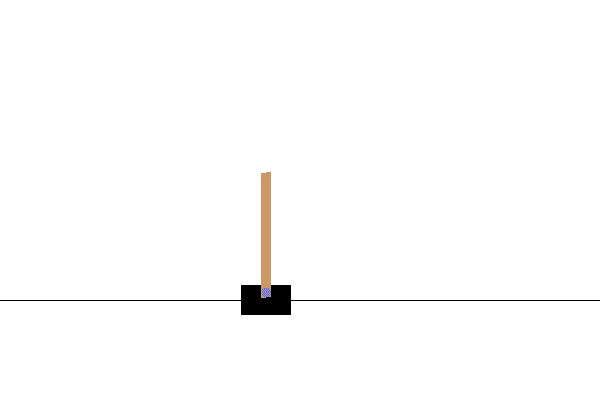

In [26]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

In [27]:
policy = reinforce_baseline_agent.policy
images = render_episode(env, policy, 1000)
image_file = 'cartpole-v1-reinforce.gif'
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


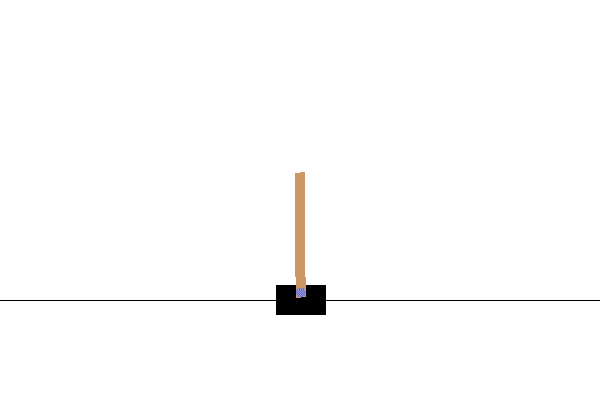

In [28]:
embed.embed_file(image_file)